# 🤖 Robot Odometry Trajectory Analysis

Simple and clean analysis of robot trajectories from ROS2 odometry data.

### Data Sources:
- **Odometry**: `/robomaster/odom` (position and velocities)
- **IMU**: `/robomaster/imu` (orientation data)

### Analysis Output:
- 2D trajectory visualization
- Position and orientation over time
- Movement statistics

In [16]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# ROS2 bag reading
try:
    import rosbag2_py
    from rclpy.serialization import deserialize_message
    from rosidl_runtime_py.utilities import get_message
    print("✅ ROS2 libraries loaded")
except ImportError:
    print("❌ ROS2 libraries not found!")
    print("Run: source /opt/ros/humble/setup.bash")

# Configure plotting
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['font.size'] = 11
plt.style.use('default')

print("🤖 Ready for odometry analysis!")

✅ ROS2 libraries loaded
🤖 Ready for odometry analysis!


In [17]:
# Configuration - Update your bag file path
BAG_FILE = "/home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/"

# Verify bag exists
if os.path.exists(BAG_FILE):
    print(f"✅ Bag found: {BAG_FILE}")
else:
    print(f"❌ Bag not found: {BAG_FILE}")
    print("Update BAG_FILE path above")

print("\n📊 Expected topics:")
print("   • /robomaster/odom (odometry data)")
print("   • /robomaster/imu (orientation)")

✅ Bag found: /home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/

📊 Expected topics:
   • /robomaster/odom (odometry data)
   • /robomaster/imu (orientation)


In [18]:
# Read odometry data from bag
def read_odometry_data(bag_path):
    """Extract odometry data from ROS2 bag"""
    if not os.path.exists(bag_path):
        return []
    
    odom_data = []
    
    try:
        reader = rosbag2_py.SequentialReader()
        reader.open(
            rosbag2_py.StorageOptions(uri=bag_path, storage_id='sqlite3'),
            rosbag2_py.ConverterOptions(
                input_serialization_format='cdr',
                output_serialization_format='cdr'
            )
        )
        
        # Read odometry topic
        storage_filter = rosbag2_py.StorageFilter(topics=['/robomaster/odom'])
        reader.set_filter(storage_filter)
        
        odom_msg_type = get_message('nav_msgs/msg/Odometry')
        
        while reader.has_next():
            topic, data, timestamp = reader.read_next()
            odom_msg = deserialize_message(data, odom_msg_type)
            
            # Extract position
            x = odom_msg.pose.pose.position.x
            y = odom_msg.pose.pose.position.y
            
            # Extract orientation (quaternion to yaw)
            qx = odom_msg.pose.pose.orientation.x
            qy = odom_msg.pose.pose.orientation.y
            qz = odom_msg.pose.pose.orientation.z
            qw = odom_msg.pose.pose.orientation.w
            yaw = np.arctan2(2.0 * (qw * qz + qx * qy), 1.0 - 2.0 * (qy * qy + qz * qz))
            
            # Extract velocities
            vx = odom_msg.twist.twist.linear.x
            vy = odom_msg.twist.twist.linear.y
            wz = odom_msg.twist.twist.angular.z
            
            odom_data.append({
                'timestamp': timestamp / 1e9,
                'x': x,
                'y': y,
                'yaw': yaw,
                'yaw_deg': np.degrees(yaw),
                'vx': vx,
                'vy': vy,
                'wz': wz,
                'speed': np.sqrt(vx*vx + vy*vy)
            })
            
    except Exception as e:
        print(f"❌ Error reading odometry: {e}")
        return []
    
    print(f"✅ Read {len(odom_data)} odometry points")
    return odom_data

print("✅ Odometry reader ready")

✅ Odometry reader ready


In [19]:
# Load and analyze odometry data
print("🔄 Loading odometry data...")

odom_data = read_odometry_data(BAG_FILE)

if not odom_data:
    print("❌ No odometry data found!")
    print("Make sure /robomaster/odom is in your bag file")
else:
    # Convert to DataFrame
    df = pd.DataFrame(odom_data)
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')
    df['time_rel'] = df['timestamp'] - df['timestamp'].iloc[0]
    
    # Calculate trajectory metrics
    duration = df['time_rel'].iloc[-1]
    
    # Calculate distance traveled
    distances = []
    for i in range(1, len(df)):
        dx = df['x'].iloc[i] - df['x'].iloc[i-1]
        dy = df['y'].iloc[i] - df['y'].iloc[i-1]
        distances.append(np.sqrt(dx*dx + dy*dy))
    total_distance = sum(distances)
    
    # Summary statistics
    print(f"\n🤖 TRAJECTORY SUMMARY:")
    print(f"   ⏱️  Duration: {duration:.1f} seconds")
    print(f"   📍 Data points: {len(df)}")
    print(f"   📏 Total distance: {total_distance:.2f} meters")
    print(f"   📊 X range: {df['x'].min():.2f} to {df['x'].max():.2f} m")
    print(f"   📊 Y range: {df['y'].min():.2f} to {df['y'].max():.2f} m")
    print(f"   🧭 Heading range: {df['yaw_deg'].min():.0f}° to {df['yaw_deg'].max():.0f}°")
    print(f"   ⚡ Max speed: {df['speed'].max():.2f} m/s")
    print(f"   ⚡ Avg speed: {df['speed'].mean():.2f} m/s")
    
    print(f"\n📋 First few data points:")
    print(df[['time_rel', 'x', 'y', 'yaw_deg', 'speed']].head())

🔄 Loading odometry data...
✅ Read 449 odometry points

🤖 TRAJECTORY SUMMARY:
   ⏱️  Duration: 45.8 seconds
   📍 Data points: 449
   📏 Total distance: 11.01 meters
   📊 X range: 0.27 to 2.56 m
   📊 Y range: -1.17 to 1.11 m
   🧭 Heading range: -179° to 179°
   ⚡ Max speed: 0.98 m/s
   ⚡ Avg speed: 0.27 m/s

📋 First few data points:
   time_rel        x        y  yaw_deg  speed
0  0.000000  0.68442 -0.87674    24.37   0.05
1  0.105112  0.68410 -0.87657    24.38   0.05
2  0.201517  0.68413 -0.87640    24.40   0.05
3  0.302402  0.68396 -0.87593    24.39   0.05
4  0.401430  0.68360 -0.87612    24.40   0.05

🤖 TRAJECTORY SUMMARY:
   ⏱️  Duration: 45.8 seconds
   📍 Data points: 449
   📏 Total distance: 11.01 meters
   📊 X range: 0.27 to 2.56 m
   📊 Y range: -1.17 to 1.11 m
   🧭 Heading range: -179° to 179°
   ⚡ Max speed: 0.98 m/s
   ⚡ Avg speed: 0.27 m/s

📋 First few data points:
   time_rel        x        y  yaw_deg  speed
0  0.000000  0.68442 -0.87674    24.37   0.05
1  0.105112  0.68410 -

[INFO] [1757444348.548381321] [rosbag2_storage]: Opened database '/home/davide/hogwarts/ros-server/experiment_bags/test_08_2025-09-09T18-57-41-386Z/test_08_2025-09-09T18-57-41-386Z_0.db3' for READ_ONLY.


/tmp/ipykernel_55816/1758874579.py:95: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/1758874579.py:95: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_55816/1758874579.py:95: UserWarning: Glyph 129517 (\N{COMPASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/davide/hogwarts/ros-server/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128506 (\N{WORLD MAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/davide/hogwarts/ros-server/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/davide/hogwarts/ros-server/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129517 (\N{COMPASS}) missing fr

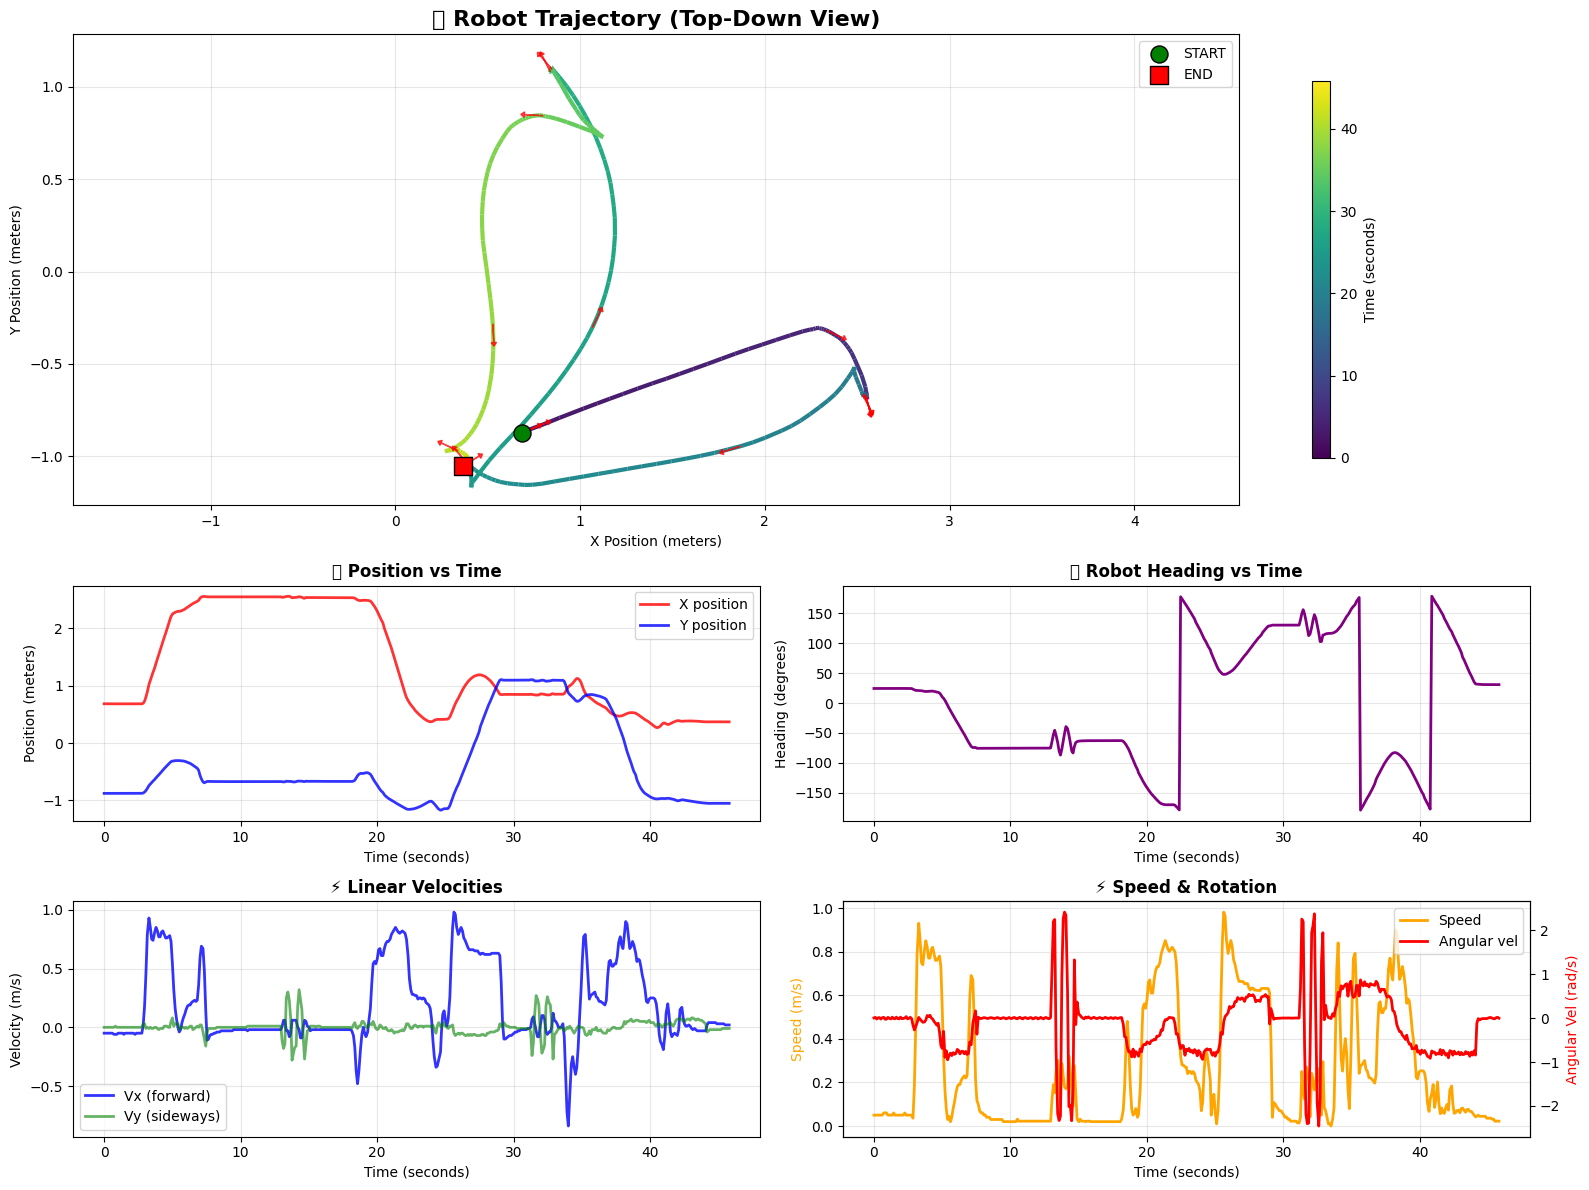

✅ Trajectory visualization complete!

📊 Plot explanation:
   • Top: 2D path with time progression (dark→light = start→end)
   • Red arrows show robot orientation
   • Middle: Position and heading changes over time
   • Bottom: Velocity profiles


In [20]:
# Visualize trajectory
if 'df' in locals() and not df.empty:
    
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 1])
    
    # 1. Main 2D trajectory plot
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot trajectory with time-based color gradient
    points = np.array([df['x'], df['y']]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    from matplotlib.collections import LineCollection
    lc = LineCollection(segments, cmap='viridis', linewidths=3)
    lc.set_array(df['time_rel'])
    line = ax1.add_collection(lc)
    
    # Mark start and end
    ax1.scatter(df['x'].iloc[0], df['y'].iloc[0], 
               color='green', s=150, marker='o', label='START', zorder=10, edgecolor='black')
    ax1.scatter(df['x'].iloc[-1], df['y'].iloc[-1], 
               color='red', s=150, marker='s', label='END', zorder=10, edgecolor='black')
    
    # Add orientation arrows
    N = max(1, len(df) // 15)
    for i in range(0, len(df), N):
        robot_x = df['x'].iloc[i]
        robot_y = df['y'].iloc[i]
        robot_yaw = df['yaw'].iloc[i]
        
        arrow_length = 0.1
        dx = arrow_length * np.cos(robot_yaw)
        dy = arrow_length * np.sin(robot_yaw)
        
        ax1.arrow(robot_x, robot_y, dx, dy, 
                 head_width=0.03, head_length=0.02, 
                 fc='red', ec='red', alpha=0.7, zorder=5)
    
    ax1.set_title('🗺️ Robot Trajectory (Top-Down View)', fontsize=16, fontweight='bold')
    ax1.set_xlabel('X Position (meters)')
    ax1.set_ylabel('Y Position (meters)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    
    # Colorbar
    cbar = plt.colorbar(line, ax=ax1, shrink=0.8)
    cbar.set_label('Time (seconds)', fontsize=10)
    
    # 2. Position vs Time
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(df['time_rel'], df['x'], 'r-', linewidth=2, label='X position', alpha=0.8)
    ax2.plot(df['time_rel'], df['y'], 'b-', linewidth=2, label='Y position', alpha=0.8)
    ax2.set_title('📍 Position vs Time', fontweight='bold')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Position (meters)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Heading vs Time
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(df['time_rel'], df['yaw_deg'], 'purple', linewidth=2)
    ax3.set_title('🧭 Robot Heading vs Time', fontweight='bold')
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Heading (degrees)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Velocities
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(df['time_rel'], df['vx'], 'b-', linewidth=2, label='Vx (forward)', alpha=0.8)
    ax4.plot(df['time_rel'], df['vy'], 'g-', linewidth=2, label='Vy (sideways)', alpha=0.6)
    ax4.set_title('⚡ Linear Velocities', fontweight='bold')
    ax4.set_xlabel('Time (seconds)')
    ax4.set_ylabel('Velocity (m/s)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Speed and Angular Velocity
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(df['time_rel'], df['speed'], 'orange', linewidth=2, label='Speed')
    ax5_twin = ax5.twinx()
    ax5_twin.plot(df['time_rel'], df['wz'], 'red', linewidth=2, label='Angular vel')
    ax5.set_title('⚡ Speed & Rotation', fontweight='bold')
    ax5.set_xlabel('Time (seconds)')
    ax5.set_ylabel('Speed (m/s)', color='orange')
    ax5_twin.set_ylabel('Angular Vel (rad/s)', color='red')
    ax5.grid(True, alpha=0.3)
    
    # Combined legend
    lines1, labels1 = ax5.get_legend_handles_labels()
    lines2, labels2 = ax5_twin.get_legend_handles_labels()
    ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Trajectory visualization complete!")
    print("\n📊 Plot explanation:")
    print("   • Top: 2D path with time progression (dark→light = start→end)")
    print("   • Red arrows show robot orientation")
    print("   • Middle: Position and heading changes over time")
    print("   • Bottom: Velocity profiles")
    
else:
    print("❌ No trajectory data to visualize")